In [7]:
pip install pandas numpy matplotlib seaborn mlxtend networkx squarify


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from operator import attrgetter
from mlxtend.frequent_patterns import apriori, association_rules
import networkx as nx
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


In [9]:
data=pd.read_excel('test.xlsx',sheet_name="Raw data")
data2= data[data['Status'] != 'Huỷ']
cohort_test=pd.read_excel('test.xlsx',sheet_name="cohort")


In [10]:
cohort_test['Create_date'] = pd.to_datetime(cohort_test['Create_date'])

In [11]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OrderID           16026 non-null  object        
 1   Create_date       16026 non-null  object        
 2   Complete_date     12399 non-null  datetime64[ns]
 3   Status            16026 non-null  object        
 4   SKU               15120 non-null  object        
 5   Qty               16026 non-null  int64         
 6   Order_value       16026 non-null  int64         
 7   Shop_voucher      16026 non-null  int64         
 8   Platform_voucher  16026 non-null  int64         
 9   CustomerID        16026 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 1.2+ MB


In [12]:
cohort_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7453 entries, 0 to 7452
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   OrderID      7453 non-null   object        
 1   Order_value  7453 non-null   int64         
 2   CustomerID   7453 non-null   object        
 3   Create_date  7453 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 233.0+ KB


In [13]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16026 entries, 0 to 16025
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   OrderID           16026 non-null  object        
 1   Create_date       16026 non-null  object        
 2   Complete_date     12399 non-null  datetime64[ns]
 3   Status            16026 non-null  object        
 4   SKU               15120 non-null  object        
 5   Qty               16026 non-null  int64         
 6   Order_value       16026 non-null  int64         
 7   Shop_voucher      16026 non-null  int64         
 8   Platform_voucher  16026 non-null  int64         
 9   CustomerID        16026 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(5)
memory usage: 1.2+ MB


In [14]:
# Tạo cột CohortMonth
cohort_test['CohortMonth'] = cohort_test.groupby('CustomerID')['Create_date'].transform('min').dt.to_period('M')

# Tạo cột OrderMonth
cohort_test['OrderMonth'] = cohort_test['Create_date'].dt.to_period('M')

# Tạo cột CohortIndex



# Đặt các giá trị không hợp lệ thành NaN
cohort_test['CohortIndex'] = cohort_test['CohortIndex'].fillna(pd.NA)

# Tạo pivot table cho cohort
cohort_data = cohort_test.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID', aggfunc=pd.Series.nunique)

# Tính cohort size
cohort_size = cohort_data.iloc[:, 0]

# Chuyển đổi thành tỷ lệ phần trăm
retention_matrix = cohort_data.divide(cohort_size, axis=0)
retention_matrix = retention_matrix.reset_index()

# Hiển thị retention_matrix
print(retention_matrix)

# Vẽ biểu đồ cohort
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Analysis - User Retention')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')
plt.show()

KeyError: 'CohortIndex'

CohortIndex  0.0       1.0       2.0       3.0       4.0       5.0       6.0   \
CohortMonth                                                                     
2023-01       1.0  0.291209  0.395604  0.192308  0.329670  0.269231  0.197802   
2023-02       1.0  0.423358  0.145985  0.321168  0.197080  0.189781  0.218978   
2023-03       1.0  0.112033  0.269710  0.182573  0.174274  0.165975  0.161826   
2023-04       1.0  0.209877  0.308642  0.172840  0.160494  0.160494  0.160494   
2023-05       1.0  0.288889  0.244444  0.244444  0.231111  0.195556  0.186667   
2023-06       1.0  0.265306  0.301020  0.239796  0.147959  0.147959  0.168367   
2023-07       1.0  0.338235  0.367647  0.253676  0.224265  0.172794       NaN   
2023-08       1.0  0.367521  0.230769  0.239316  0.196581       NaN       NaN   
2023-09       1.0  0.275591  0.217848  0.207349       NaN       NaN       NaN   
2023-10       1.0  0.320833  0.220833       NaN       NaN       NaN       NaN   
2023-11       1.0  0.275568 

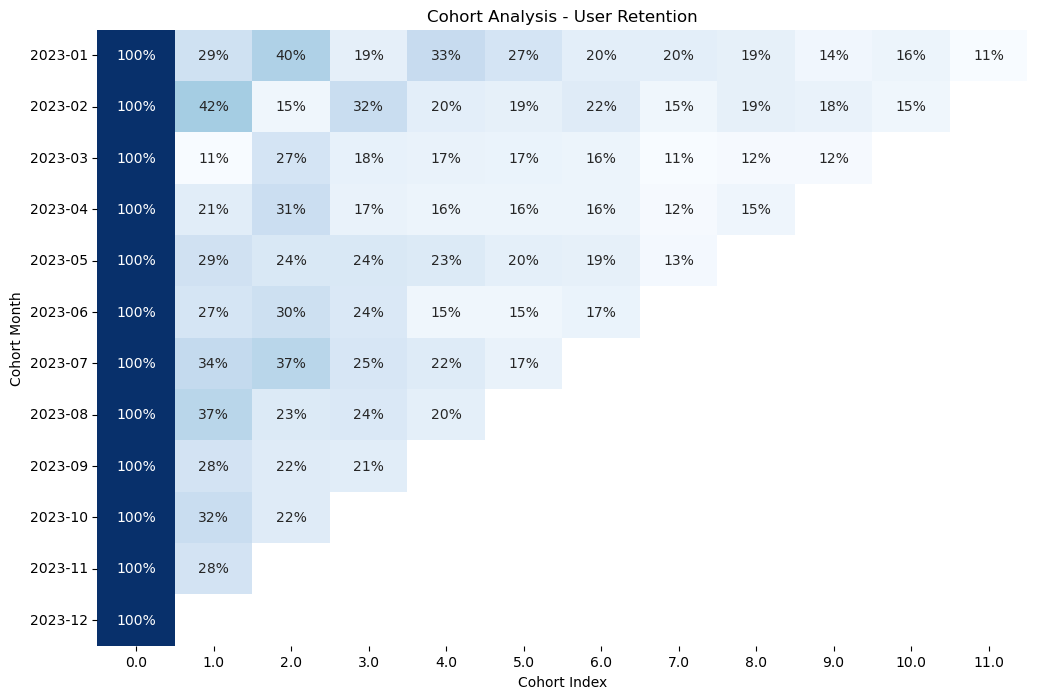

In [ ]:
# Tạo cột CohortMonth
cohort_test['CohortMonth'] = cohort_test.groupby('CustomerID')['Create_date'].transform('min').dt.to_period('M')

# Tạo cột OrderMonth
cohort_test['OrderMonth'] = cohort_test['Create_date'].dt.to_period('M')

# Xác định mask hợp lệ
valid_mask = cohort_test['CohortMonth'].notna() & cohort_test['OrderMonth'].notna()

# Tạo cột CohortIndex
cohort_test.loc[valid_mask, 'CohortIndex'] = (cohort_test.loc[valid_mask, 'OrderMonth'] - cohort_test.loc[valid_mask, 'CohortMonth']).apply(attrgetter('n'))

# Đặt các giá trị không hợp lệ thành NaN
cohort_test['CohortIndex'] = cohort_test['CohortIndex'].fillna(pd.NA)

# Tạo pivot table cho cohort
cohort_data = cohort_test.pivot_table(index='CohortMonth', columns='CohortIndex', values='CustomerID', aggfunc=pd.Series.nunique)

# Tính cohort size
cohort_size = cohort_data.iloc[:, 0]

# Chuyển đổi thành tỷ lệ phần trăm
retention_matrix = cohort_data.divide(cohort_size, axis=0)

# Hiển thị retention_matrix
print(retention_matrix)

# Vẽ biểu đồ cohort
plt.figure(figsize=(12, 8))
sns.heatmap(data=retention_matrix, annot=True, fmt='.0%', cmap='Blues', cbar=False)
plt.title('Cohort Analysis - User Retention')
plt.xlabel('Cohort Index')
plt.ylabel('Cohort Month')
plt.show()

OrderMonth
2023-01    182
2023-02    137
2023-03    241
2023-04     81
2023-05    225
2023-06    196
2023-07    272
2023-08    351
2023-09    381
2023-10    240
2023-11    352
2023-12    445
Freq: M, Name: CustomerID, dtype: int64


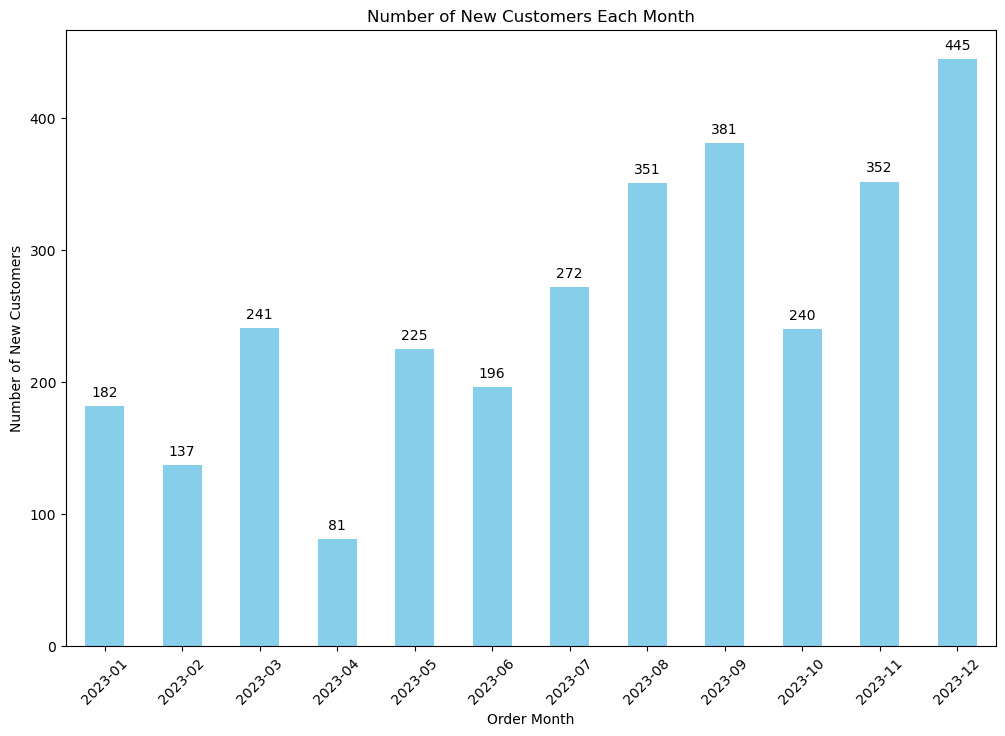

In [ ]:
# Xác định số lượng khách hàng mới mỗi tháng
new_customers = cohort_test[cohort_test['CohortMonth'] == cohort_test['OrderMonth']]
new_customers_count = new_customers.groupby('OrderMonth')['CustomerID'].nunique()

# Hiển thị new_customers_count
print(new_customers_count)


# Vẽ biểu đồ khách hàng mới mỗi tháng
plt.figure(figsize=(12, 8))
ax = new_customers_count.plot(kind='bar', color='skyblue')
plt.title('Number of New Customers Each Month')
plt.xlabel('Order Month')
plt.ylabel('Number of New Customers')
plt.xticks(rotation=45)


# Thêm nhãn cho từng cột
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points')

plt.show()

In [ ]:
cohort_test

,OrderID,Order_value,CustomerID,Create_date,CohortMonth,OrderMonth
0,OP230131S5PABM5AFGRD,579000,SE12OP,2023-01-31,2023-01,2023-01
1,OP23020206YTAR1AFGRD,1432000,SEmdai20912OP,2023-02-02,2023-02,2023-02
2,OP230303DVTYV5D8FGRD,2109000,SEtrantran_22612OP,2023-03-03,2023-03,2023-03
3,OP230303ESGGQ8D6FGRD,3330000,SEconchimnon221812OP,2023-03-03,2023-02,2023-03
4,OP230315FPG3SXGDFGRD,579000,SEbichvan639612OP,2023-03-15,2023-03,2023-03
...,...,...,...,...,...,...
7448,OP231228CD2B4JDAFGRD,346000,SEthuy_an.0812OP,2023-12-28,2023-12,2023-12
7449,OP231228CV5KVB6QFGRD,346000,SEvera_399812OP,2023-12-28,2023-11,2023-12
7450,OP231230HY4NF9QUFGRD,759000,SEgiadungthuna12OP,2023-12-30,2023-12,2023-12
7451,OP231231M6BTKC1SFGRD,2277000,SEheoxinhxinh9412OP,2023-12-31,2023-12,2023-12


In [ ]:
retention_matrix.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 12 entries, 2023-01 to 2023-12
Freq: M
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0.0     12 non-null     float64
 1   1.0     11 non-null     float64
 2   2.0     10 non-null     float64
 3   3.0     9 non-null      float64
 4   4.0     8 non-null      float64
 5   5.0     7 non-null      float64
 6   6.0     6 non-null      float64
 7   7.0     5 non-null      float64
 8   8.0     4 non-null      float64
 9   9.0     3 non-null      float64
 10  10.0    2 non-null      float64
 11  11.0    1 non-null      float64
dtypes: float64(12)
memory usage: 1.2 KB


CustomerID
SE.mr.binh12OP                 High spenders, frequent buyers
SE0349487999_mudita12OP      High spenders, infrequent buyers
SE047jj859s812OP              Low spenders, infrequent buyers
SE0601vankhanh12OP            Low spenders, infrequent buyers
SE0777897138h12OP            High spenders, infrequent buyers
                                          ...                
SEzsce7oo80a12OP             High spenders, infrequent buyers
SEzulyyyyyyyy12OP             Low spenders, infrequent buyers
SEzung1012OP                  Low spenders, infrequent buyers
SEzungzjn12OP              Medium spenders, infrequent buyers
SEzwnbg7no2312OP           Medium spenders, infrequent buyers
Length: 3645, dtype: object


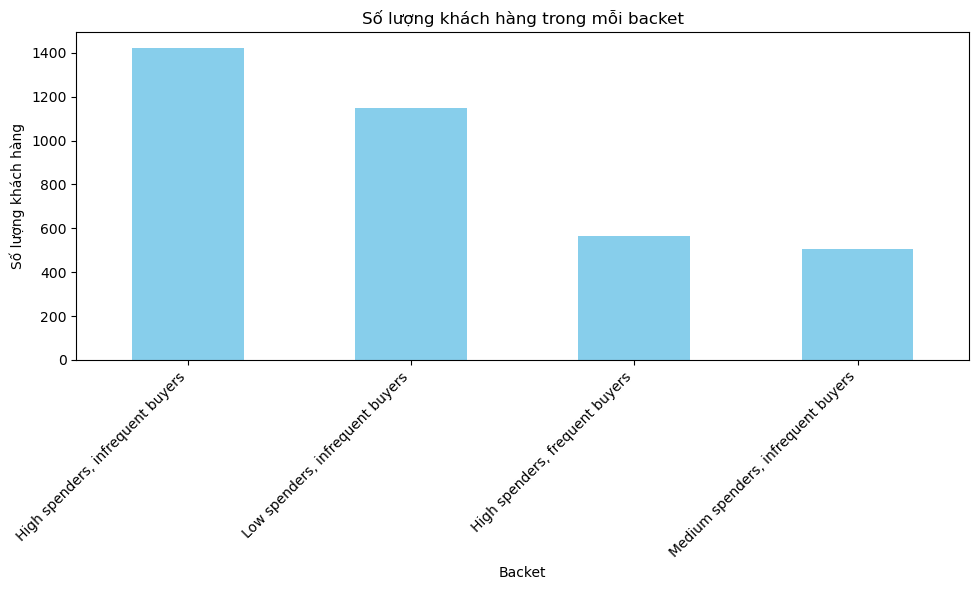

In [ ]:
# Tính tổng số tiền mỗi khách hàng đã chi tiêu
customer_spending = data2.groupby('CustomerID')['Order_value'].sum()

# Tính tần suất mua hàng của mỗi khách hàng
order_frequency = data2.groupby('CustomerID')['OrderID'].nunique()

# Tạo backet dựa trên mức độ chi tiêu và tần suất mua hàng
def create_bucket(spending, frequency):
    if spending < 1000000 and frequency < 5:
        return 'Low spenders, infrequent buyers'
    elif spending < 1000000 and frequency >= 5:
        return 'Low spenders, frequent buyers'
    elif spending >= 1000000 and spending < 1500000 and frequency < 5:
        return 'Medium spenders, infrequent buyers'
    elif spending >= 1000000 and spending < 1500000 and frequency >= 5:
        return 'Medium spenders, frequent buyers'
    elif spending >= 1500000 and frequency < 5:
        return 'High spenders, infrequent buyers'
    else:
        return 'High spenders, frequent buyers'

# Tạo backet cho từng khách hàng
buckets = customer_spending.combine(order_frequency, create_bucket)

# Đếm số lượng khách hàng trong mỗi backet
bucket_counts = buckets.value_counts()
# Hiển thị backet của mỗi khách hàng
print(buckets)
plt.figure(figsize=(10, 6))
bucket_counts.plot(kind='bar', color='skyblue')
plt.title('Số lượng khách hàng trong mỗi backet')
plt.xlabel('Backet')
plt.ylabel('Số lượng khách hàng')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

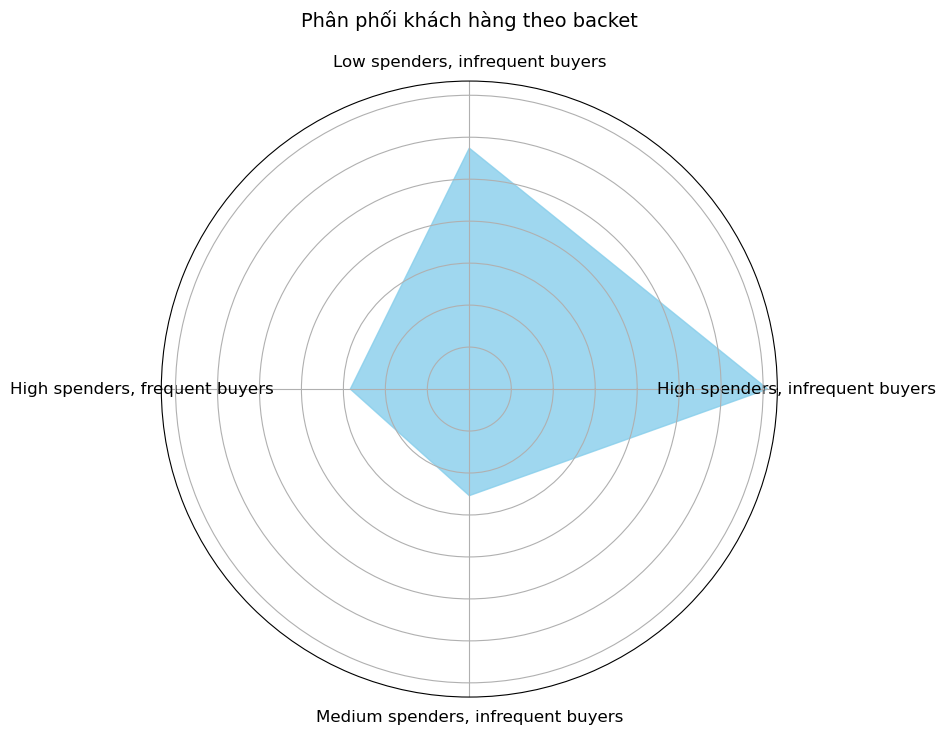

In [ ]:
# Tạo biến số mô phỏng
categories = list(bucket_counts.index)
values = bucket_counts.values

# Tạo góc
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()

# Thêm góc đầu tiên lên cuối để đóng vòng tròn
values = np.concatenate((values,[values[0]]))
angles += angles[:1]

# Vẽ biểu đồ radar
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.fill(angles, values, color='skyblue', alpha=0.8)
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)
ax.set_title('Phân phối khách hàng theo backet', fontsize=14, pad=20)
plt.show()



In [ ]:
# Phân tích phân phối của cột "Status"
status_distribution = data['Status'].count()
print("Phân phối của cột Status:")
print(status_distribution)




Phân phối của cột Status:
16026


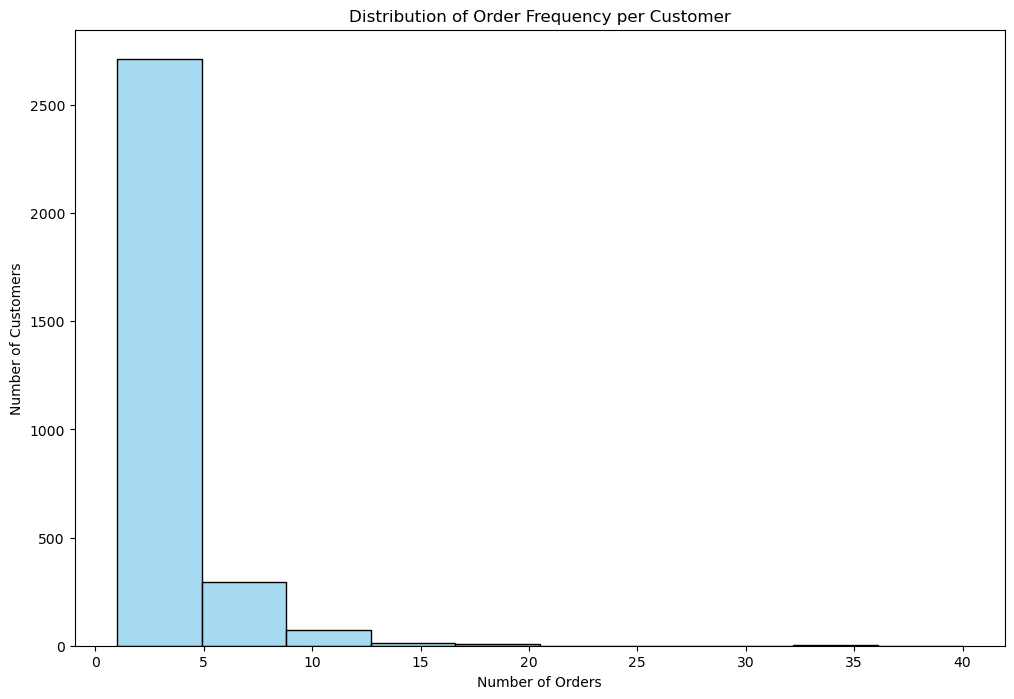

In [ ]:
orders_per_customer = cohort_test.groupby('CustomerID')['OrderID'].nunique()
plt.figure(figsize=(12, 8))
sns.histplot(orders_per_customer, bins=10, kde=False, color='skyblue')
plt.title('Distribution of Order Frequency per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.show()

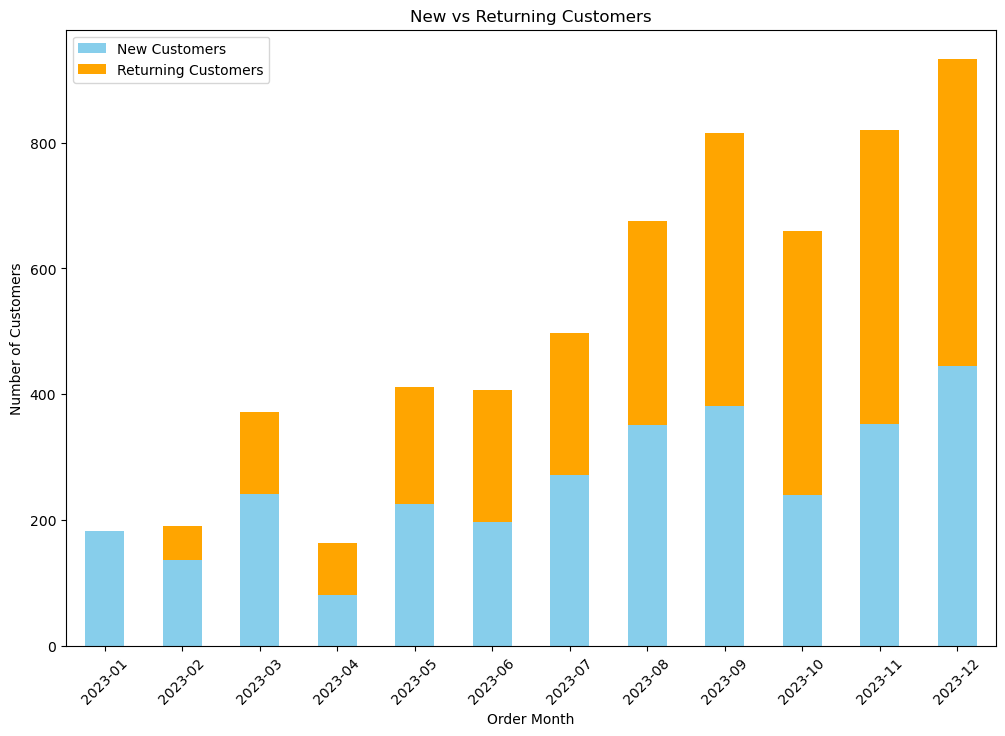

In [ ]:
# Xác định khách hàng mới và khách hàng quay lại
new_customers = cohort_test[cohort_test['CohortMonth'] == cohort_test['OrderMonth']]
new_customers_count = new_customers.groupby('OrderMonth')['CustomerID'].nunique()
returning_customers_count = cohort_test.groupby('OrderMonth')['CustomerID'].nunique() - new_customers_count

# Vẽ biểu đồ khách hàng mới và khách hàng quay lại mỗi tháng
plt.figure(figsize=(12, 8))
ax = new_customers_count.plot(kind='bar', color='skyblue', label='New Customers')
returning_customers_count.plot(kind='bar', color='orange', label='Returning Customers', bottom=new_customers_count)

plt.title('New vs Returning Customers')
plt.xlabel('Order Month')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.legend()

plt.show()

In [ ]:
# Tạo DataFrame từ số lượng khách hàng mới và quay lại
data4 = {'Order Month': new_customers_count.index,
        'New Customers': new_customers_count.values,
        'Returning Customers': returning_customers_count.values}
df = pd.DataFrame(data4)

# Hiển thị DataFrame
df.reset_index()

,index,Order Month,New Customers,Returning Customers
0,0,2023-01,182,0
1,1,2023-02,137,53
2,2,2023-03,241,130
3,3,2023-04,81,82
4,4,2023-05,225,186
5,5,2023-06,196,210
6,6,2023-07,272,225
7,7,2023-08,351,325
8,8,2023-09,381,434
9,9,2023-10,240,420


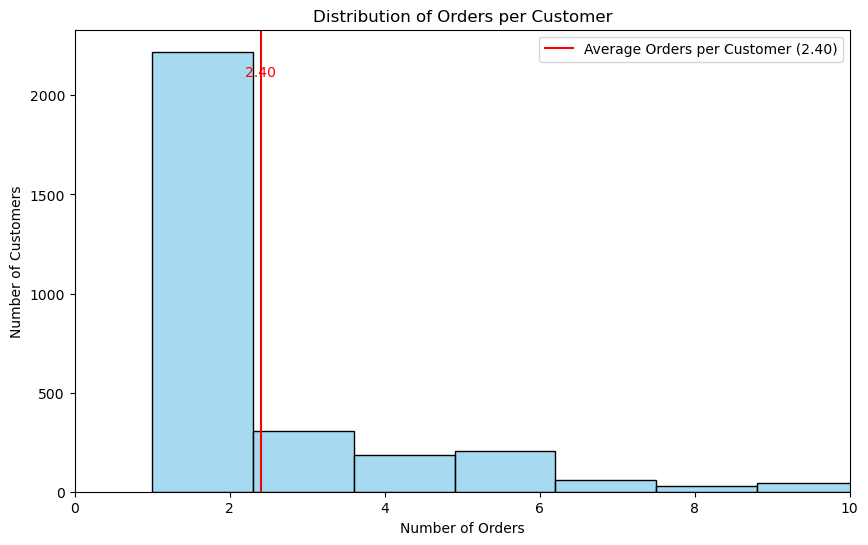

In [ ]:
# Tính số lượng đơn hàng mỗi khách hàng đã thực hiện
orders_per_customer = cohort_test.groupby('CustomerID')['OrderID'].nunique()

# Tính giá trị trung bình của số lượng đơn hàng mỗi khách hàng
average_orders_per_customer = np.mean(orders_per_customer)

# Vẽ biểu đồ cột cho phân phối số lượng đơn hàng mỗi khách hàng đã thực hiện
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_customer, bins=30, color='skyblue', edgecolor='black', kde=False)
plt.axvline(x=average_orders_per_customer, color='red', linestyle='-', label=f'Average Orders per Customer ({average_orders_per_customer:.2f})')

# Hiển thị giá trị trung bình trên biểu đồ
plt.text(average_orders_per_customer, plt.gca().get_ylim()[1]*0.9, f'{average_orders_per_customer:.2f}', color='red', ha='center')

plt.title('Distribution of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.legend()
plt.xlim(0, 10)
plt.show()

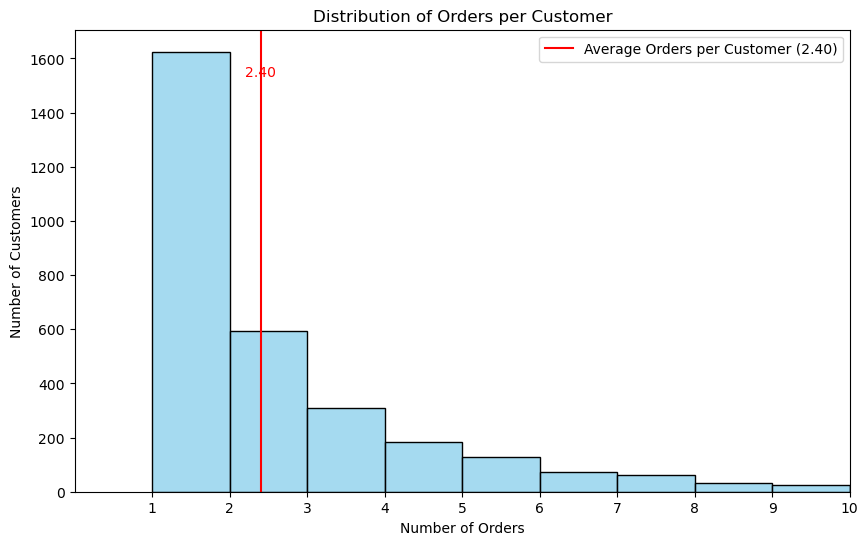

In [ ]:
# Tính số lượng đơn hàng mỗi khách hàng đã thực hiện
orders_per_customer = cohort_test.groupby('CustomerID')['OrderID'].nunique()

# Tính giá trị trung bình của số lượng đơn hàng mỗi khách hàng
average_orders_per_customer = np.mean(orders_per_customer)

# Vẽ biểu đồ cột cho phân phối số lượng đơn hàng mỗi khách hàng đã thực hiện
plt.figure(figsize=(10, 6))
sns.histplot(orders_per_customer, bins=range(1, int(orders_per_customer.max()) + 2), color='skyblue', edgecolor='black', kde=False)
plt.axvline(x=average_orders_per_customer, color='red', linestyle='-', label=f'Average Orders per Customer ({average_orders_per_customer:.2f})')

# Hiển thị giá trị trung bình trên biểu đồ
plt.text(average_orders_per_customer, plt.gca().get_ylim()[1]*0.9, f'{average_orders_per_customer:.2f}', color='red', ha='center')

plt.title('Distribution of Orders per Customer')
plt.xlabel('Number of Orders')
plt.ylabel('Number of Customers')
plt.legend()
plt.xlim(0, 10)
plt.xticks(range(1, 11))  # Hiển thị đầy đủ các giá trị trên trục x
plt.show()

In [16]:

current_date = pd.to_datetime('31-12-2023')
###
rfm = cohort_test.groupby('CustomerID').agg({'Create_date': lambda date: (current_date - date.max()).days,
                                     'OrderID': lambda num: num.nunique(),
                                     'Order_value': lambda Order_value: Order_value.sum()})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm.head()


C:\Users\OP-LT-0315\AppData\Local\Temp\ipykernel_1468\1143666883.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  current_date = pd.to_datetime('31-12-2023')


,recency,frequency,monetary
CustomerID,,,
SE.mr.binh12OP,56,7,4497000
SE0349487999_mudita12OP,332,1,1130000
SE047jj859s812OP,137,1,679000
SE0601vankhanh12OP,95,1,780000
SE0777897138h12OP,113,1,1099000


In [17]:
rfm = rfm[rfm["monetary"] > 0]

In [18]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# 1 1,1,2,3,3,3,3,3,
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
SE.mr.binh12OP,56,7,4497000,3,5,4,35
SE0349487999_mudita12OP,332,1,1130000,1,1,2,11
SE047jj859s812OP,137,1,679000,2,1,2,21
SE0601vankhanh12OP,95,1,780000,3,1,2,31
SE0777897138h12OP,113,1,1099000,2,1,2,21


In [19]:
rfm[rfm["RFM_SCORE"] == "55"].head()


,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
SE0l29uk_3fe12OP,19,7,8940000,5,5,5,55
SE31e5lott3m12OP,19,5,4887000,5,5,5,55
SE6q0oz2tqd312OP,19,5,11663000,5,5,5,55
SE6ulw2whdi912OP,9,8,23388000,5,5,5,55
SEalexchun170412OP,6,12,22386000,5,5,5,55


In [20]:
rfm[rfm["RFM_SCORE"] == "11"].head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE
CustomerID,,,,,,,
SE0349487999_mudita12OP,332,1,1130000,1,1,2,11
SE1y4r46wlf612OP,195,1,599000,1,1,1,11
SE4is5ex9wqn12OP,208,1,549000,1,1,1,11
SE68111u3oc112OP,332,1,2735000,1,1,4,11
SEa7ls27q5l912OP,271,1,325000,1,1,1,11


In [21]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)
rfm.head()

,recency,frequency,monetary,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
CustomerID,,,,,,,,
SE.mr.binh12OP,56,7,4497000,3,5,4,35,loyal_customers
SE0349487999_mudita12OP,332,1,1130000,1,1,2,11,hibernating
SE047jj859s812OP,137,1,679000,2,1,2,21,hibernating
SE0601vankhanh12OP,95,1,780000,3,1,2,31,about_to_sleep
SE0777897138h12OP,113,1,1099000,2,1,2,21,hibernating


In [22]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3103 entries, SE.mr.binh12OP to SEzwnbg7no2312OP
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   recency          3103 non-null   int64   
 1   frequency        3103 non-null   int64   
 2   monetary         3103 non-null   int64   
 3   recency_score    3103 non-null   category
 4   frequency_score  3103 non-null   category
 5   monetary_score   3103 non-null   category
 6   RFM_SCORE        3103 non-null   object  
 7   segment          3103 non-null   object  
dtypes: category(3), int64(3), object(2)
memory usage: 155.2+ KB


C:\Users\OP-LT-0315\AppData\Roaming\Python\Python311\site-packages\squarify\__init__.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap()


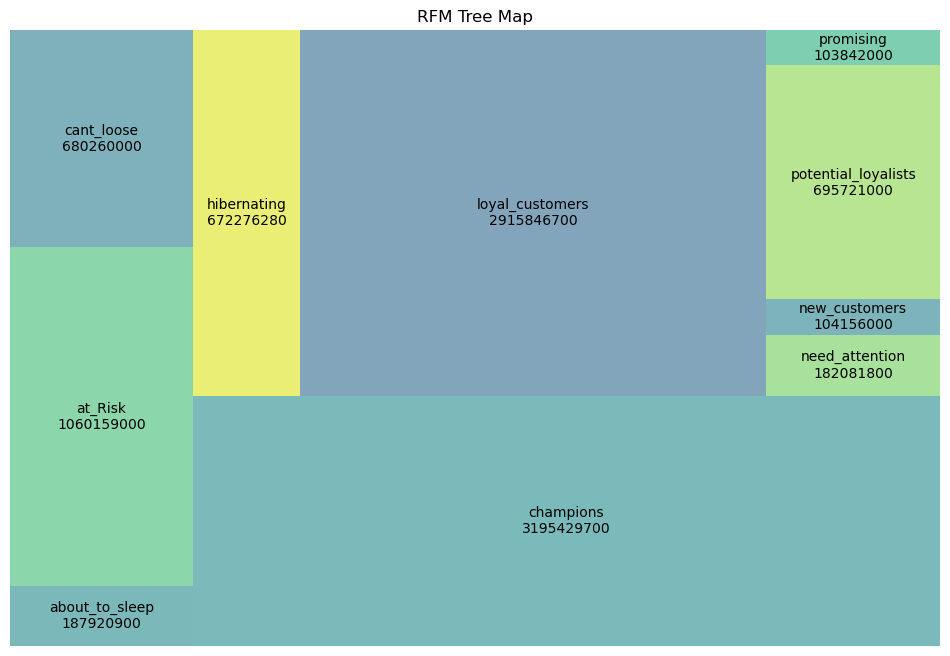

In [25]:
# Tính toán tổng giá trị monetary cho mỗi segment
tree_map_data = rfm.groupby('segment').agg({'monetary': 'sum'}).reset_index()
tree_map_data['size'] = tree_map_data['monetary']

# Vẽ tree map
plt.figure(figsize=(12, 8))
squarify.plot(sizes=tree_map_data['size'], label=tree_map_data['segment'] + "\n" + tree_map_data['size'].astype(str), alpha=.6)
plt.title('RFM Tree Map')
plt.axis('off')
plt.show()

C:\Users\OP-LT-0315\AppData\Local\Temp\ipykernel_1468\490682987.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  current_date = pd.to_datetime('31-12-2023')
C:\Users\OP-LT-0315\AppData\Roaming\Python\Python311\site-packages\squarify\__init__.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap()


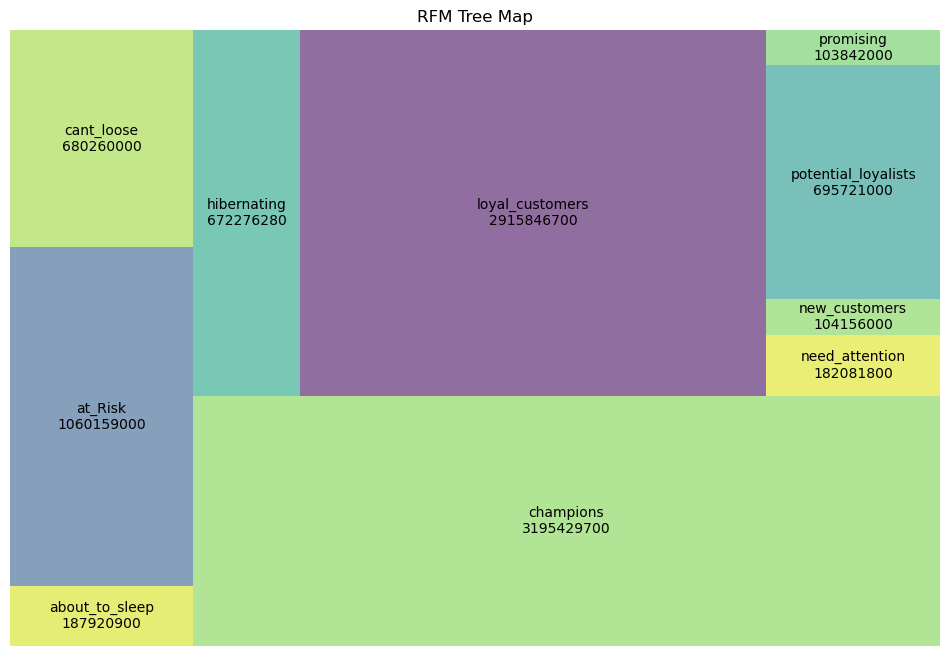

In [27]:
current_date = pd.to_datetime('31-12-2023')
###
rfm = cohort_test.groupby('CustomerID').agg({'Create_date': lambda date: (current_date - date.max()).days,
                                     'OrderID': lambda num: num.nunique(),
                                     'Order_value': lambda Order_value: Order_value.sum()})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
# 1 1,1,2,3,3,3,3,3,
rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) +
                    rfm['frequency_score'].astype(str))

seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}
rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

# Tính toán tổng giá trị monetary cho mỗi segment
tree_map_data = rfm.groupby('segment').agg({'monetary': 'sum'}).reset_index()
tree_map_data['size'] = tree_map_data['monetary']

# Vẽ tree map
plt.figure(figsize=(12, 8))
squarify.plot(sizes=tree_map_data['size'], label=tree_map_data['segment'] + "\n" + tree_map_data['size'].astype(str), alpha=.6)
plt.title('RFM Tree Map')
plt.axis('off')
plt.show()

C:\Users\OP-LT-0315\AppData\Local\Temp\ipykernel_1468\4092221906.py:4: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  current_date = pd.to_datetime('31-12-2023')
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  return lib.map_infer(values, mapper, convert=convert)
c:\ProgramData\anaconda3\Lib\site-packages\pandas\core\algorithms.py:1814: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.

            recency  frequency      monetary
cluster                                     
0         62.187061   1.667001  1.843050e+06
1         50.552536   6.019928  8.665323e+06
2        245.155804   1.539715  1.705658e+06
3         16.750000  51.000000  1.074410e+08
4         35.389381  12.955752  2.199883e+07


C:\Users\OP-LT-0315\AppData\Roaming\Python\Python311\site-packages\squarify\__init__.py:231: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap()


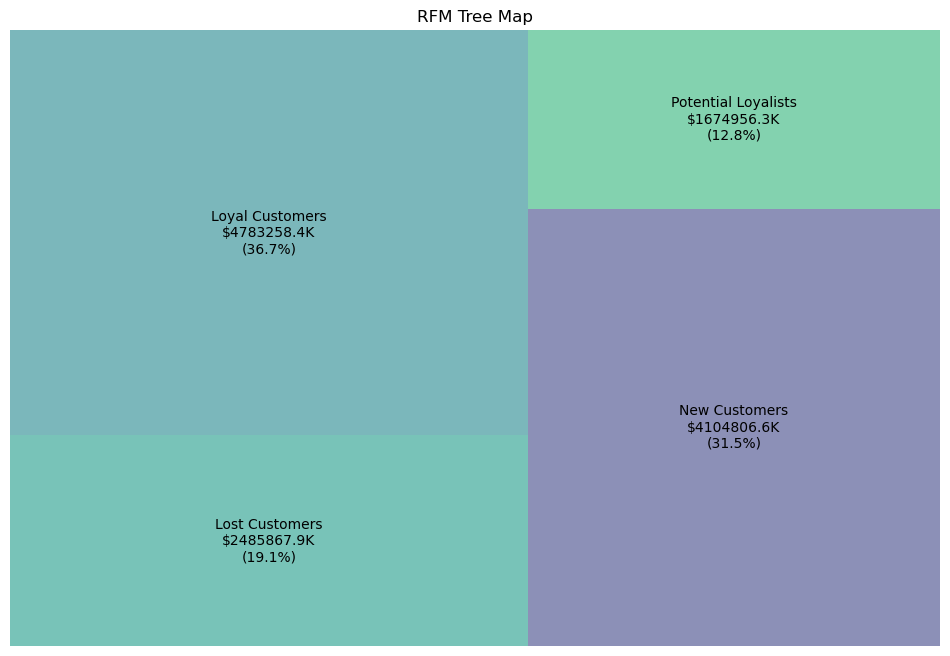

In [38]:
cohort_test = pd.DataFrame(data)
cohort_test['Create_date'] = pd.to_datetime(cohort_test['Create_date'])

current_date = pd.to_datetime('31-12-2023')
rfm = cohort_test.groupby('CustomerID').agg({
    'Create_date': lambda date: (current_date - date.max()).days,
    'OrderID': lambda num: num.nunique(),
    'Order_value': lambda Order_value: Order_value.sum()
})
rfm.columns = ['recency', 'frequency', 'monetary']
rfm = rfm[rfm["monetary"] > 0]
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(rfm_scaled)
rfm['cluster'] = kmeans.labels_
# Tính toán giá trị trung bình cho từng cụm
cluster_summary = rfm.groupby('cluster').mean()
print(cluster_summary)
# Đặt tên cho các clusters
cluster_map = {
    0: 'New Customers',         # Thấp recency, cao frequency, cao monetary
    1: 'Loyal Customers',   # Trung bình recency, cao frequency, trung bình monetary
    2: 'Potential Loyalists', # Thấp recency, trung bình frequency, trung bình monetary
    3: 'New Customers',     # Thấp recency, thấp frequency, thấp monetary
    4: 'Lost Customers'     # Cao recency, thấp frequency, thấp monetary
}
rfm['segment'] = rfm['cluster'].map(cluster_map)
# Tính toán tổng giá trị monetary cho mỗi segment
tree_map_data = rfm.groupby('segment').agg({'monetary': 'sum'}).reset_index()
tree_map_data['size'] = tree_map_data['monetary']

# Tính toán phần trăm và định dạng số liệu theo đơn vị hàng nghìn
total_monetary = tree_map_data['monetary'].sum()
tree_map_data['percent'] = (tree_map_data['monetary'] / total_monetary) * 100
tree_map_data['label'] = tree_map_data.apply(lambda x: f"{x['segment']}\n${x['monetary']/1000:.1f}K\n({x['percent']:.1f}%)", axis=1)

# Vẽ tree map
plt.figure(figsize=(12, 8))
squarify.plot(sizes=tree_map_data['size'], label=tree_map_data['label'], alpha=.6)
plt.title('RFM Tree Map')
plt.axis('off')
plt.show()








In [37]:
# Tính toán giá trị trung bình cho từng cụm
cluster_summary = rfm.groupby('cluster').mean()
print(cluster_summary)


TypeError: agg function failed [how->mean,dtype->object]